In [1]:
%matplotlib notebook

import os
import sys
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Import dependencies and set random seed
seed_value = 5
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

sys.path.insert(0, os.path.abspath('Support'))

from Obstacle import *

# RTT Algorithm

The class below shows a possible implementation of the RTT planning algorithm. The main methods are:

``get_random_node(.)``, this method uniformly samples a new point in the space.

``get_nearest_node_index(.)``, this method finds the index of the node in the tree that is the closest to a query node.

``steer(.)``, given two nodes n_expansion and n_random to_node, this method generate a node n_nearby such that n_nearby is “closer” to n_random than to n_expansion.

``is_collision_free(.)``, this method determines whether a new node is within the free-collision space

``planning(.)``, this is the main algorithm. Starting with a node at the start location, this method incrementally adds new nodes to the tree roadmap. The main steps are:

1. Generate a random node ``rnd_node``

2. Select the node in the tree that is the closest ``rnd_node``. We refer to this node as ``expansion_node``.

3. Choose a collision-free node along the path between ``expansion_node`` and ``rnd_node``. Add the new node to the tree roadmap. This is done by using the ``steer(.)`` and ``is_collision_free(.)`` methods one after the other.

4. Repeat steps 1 to 3 until the maximum number of nodes has been reached or a path between start and goal nodes has been found.

**TODO**:
- Complete the ``planning(.)`` method. 


In [2]:
# This is an adapted version of the RRT implementation done by Atsushi Sakai (@Atsushi_twi)

class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    def __init__(self, start=np.zeros(2),
                 goal=np.array([120,90]),
                 obstacle_list=None,
                 width = 160,
                 height=100,
                 expand_dis=3.0, 
                 path_resolution=0.5, 
                 max_points=200):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacle_list: list of obstacle objects
        width, height: search area
        expand_dis: min distance between random node and closest node in rrt to it
        path_resolion: step size to considered when looking for node to expand
        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.width = width
        self.height = height
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.max_nodes = max_points
        self.obstacle_list = obstacle_list
        self.node_list = []

    def planning(self, animation=True):
        """
        rrt path planning
        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        while len(self.node_list) <= self.max_nodes:
                        
            # 1. Generate a random node           
            rnd_node = self.get_random_node()
            
            # 2. Find node in tree that is closest to sampled node.
            # This is the node to be expanded (q_expansion)
            expansion_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            expansion_node = self.node_list[expansion_ind]

            #---------------- TODO: Complete the last two main steps of the RRT algorithm ----------------
            
            # 3. Select a node (nearby_node) close to expansion_node by moving from expantion_node to rnd_node
            # Use the steer method

            # 4. Check if nearby_node is in free space (i.e., it is collision free). If collision free, add node
            # to self.node_list
 
            #-------------------------------------------------------------------------------------------
                
            # If we are close to goal, stop expansion and generate path
            if self.calc_dist_to_goal(self.node_list[-1].x, self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end, self.expand_dis)
                if self.is_collision_free(final_node):
                    return self.generate_final_course(len(self.node_list) - 1)

        return None  # cannot find path

    
    def steer(self, from_node, to_node, extend_length=float("inf")):
        """
        Given two nodes from_node, to_node, this method returns a node new_node such that new_node 
        is “closer” to to_node than from_node is.
        """
        
        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        # How many intermediate positions are considered between from_node and to_node
        n_expand = math.floor(extend_length / self.path_resolution)

        # Compute all intermediate positions
        for _ in range(n_expand):
            new_node.x += self.path_resolution * cos_theta
            new_node.y += self.path_resolution * sin_theta
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)

        new_node.parent = from_node

        return new_node


    def is_collision_free(self, new_node):
        """
        Determine if nearby_node (new_node) is in the collision-free space.
        """
        if new_node is None:
            return True

        points = np.vstack((new_node.path_x, new_node.path_y)).T
        for obs in self.obstacle_list:
            in_collision = obs.is_in_collision_with_points(points)
            if in_collision:
                return False
        
        return True  # safe
        
    
    def generate_final_course(self, goal_ind):
        """
        Reconstruct path from start to end node
        """
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        x = self.width * np.random.random_sample()
        y = self.height * np.random.random_sample()
        rnd = self.Node(x, y)
        return rnd
    
    def draw_graph(self):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                             xlim=(0, 16), ylim=(0, 12))
        ax.grid()
                
        ax.plot(self.start.x, self.start.y, "^r", lw=5)
        ax.plot(self.end.x, self.end.y, "^c", lw=5)
        
        for obs in self.obstacle_list:
            if isinstance(obs, Circle):
                cx, cy = obs.center
                self.plot_circle(ax, cx, cy, obs.radius)
            else:
                ox, oy = obs.plot_obstacle()
                ax.scatter(ox, oy, s=7, c='k')
                
        for node in self.node_list:
            if node.parent:
                ax.plot(node.path_x, node.path_y, "g.-")
        
        return fig, ax

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        # Compute Euclidean disteance between rnd_node and all nodes in tree
        # Return index of closest element
        dlist = [(node.x - rnd_node.x) ** 2 + (node.y - rnd_node.y)
                 ** 2 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta        
        
    @staticmethod
    def plot_circle(ax, x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        ax.plot(xl, yl, color)


## RTT in action

Let's see how a tree roadmap connecting a start and goal location is build

**Interaction**:
- Change the values of the parameters ``expand_dis, path_resolution`` and see how the tree roadmap changes. 
- Define new goal and start points and see how different trees and path are generated

<IPython.core.display.Javascript object>


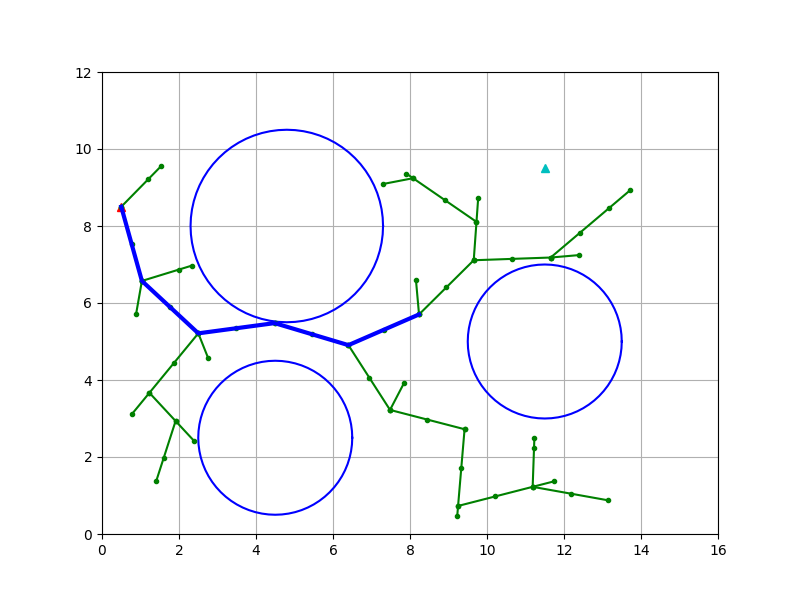

In [6]:
goal = np.array([11.5, 9.5])
start = np.array([0.5, 8.5])

all_obstacles = [Circle(11.5, 5, 2), Circle(4.5, 2.5, 2),
                 Circle(4.8, 8, 2.5)]

rrt = RRT(start=start, goal=goal, width=16, height=10, obstacle_list=all_obstacles,
          expand_dis=2.0, path_resolution=1)

path = rrt.planning()
fig, ax = rrt.draw_graph()

line_path, = ax.plot([], [], "b", lw=3)

if path:
    path_in_order = np.flipud(path)
    start_pos = path_in_order[0,:]
            
    def init():
        line_path.set_data(path_in_order[0], path_in_order[1])
        return line_path

    def animate(i):
        """perform animation step"""
        line_path.set_data(path_in_order[:i,0], path_in_order[:i, 1])
        return line_path

    ani = animation.FuncAnimation(fig, animate, frames=30, blit=True, interval=100, init_func=init)
else:
    print("Path was not found!!")

**FLUX Question (1pt)**: What the impact of an increase in the ``expand_dis`` parameter?